# Bitcoin Price Prediction - time series analysis using ARIMA and SARIMA

In [2]:
import os
from datetime import datetime
import time
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from itertools import product
import warnings
warnings.filterwarnings("ignore")
import numpy as np # linear algebra
import pandas as pd


# Data Overview

## Import data

In [3]:
assetinfo = pd.read_csv("asset_details.csv")
ctrain = pd.read_csv("train.csv")

## Asset Information and Dataset Overview

In [4]:
assetinfo

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


In [5]:
ctrain.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [6]:
ctrain.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   timestamp  24236806 non-null  int64  
 1   Asset_ID   24236806 non-null  int64  
 2   Count      24236806 non-null  float64
 3   Open       24236806 non-null  float64
 4   High       24236806 non-null  float64
 5   Low        24236806 non-null  float64
 6   Close      24236806 non-null  float64
 7   Volume     24236806 non-null  float64
 8   VWAP       24236797 non-null  float64
 9   Target     23486468 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 1.8 GB


## Generate Sorting List

In [7]:
asset_names_dict = {row["Asset_Name"]:row["Asset_ID"] for ind, row in assetinfo.iterrows()}

asset_names = [
    'Bitcoin',
    'Ethereum',
    'Cardano',
    'Binance Coin',
    'Dogecoin',
    'Bitcoin Cash',
    'Litecoin',
    'Ethereum Classic',
    'Stellar',
    'TRON',
    'Monero',
    'EOS.IO',
    'IOTA',
    'Maker'
]

## Timespan Overview

In [8]:
time_list = []
for coin in asset_names:
    coin_df = ctrain[ctrain["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")  
    beg_time = coin_df.index[0].astype('datetime64[s]') 
    end_time = coin_df.index[-1].astype('datetime64[s]') 
    time_list.append([coin, beg_time, end_time])
time_df = pd.DataFrame(time_list)
time_df.columns = ["Asset_Name", "Begin_Time", "End_Time"]
time_df

,Asset_Name,Begin_Time,End_Time
0,Bitcoin,2018-01-01 00:01:00,2021-09-21
1,Ethereum,2018-01-01 00:01:00,2021-09-21
2,Cardano,2018-04-17 09:11:00,2021-09-21
3,Binance Coin,2018-01-01 00:01:00,2021-09-21
4,Dogecoin,2019-04-12 14:34:00,2021-09-21
5,Bitcoin Cash,2018-01-01 00:01:00,2021-09-21
6,Litecoin,2018-01-01 00:01:00,2021-09-21
7,Ethereum Classic,2018-01-01 00:01:00,2021-09-21
8,Stellar,2018-02-16 23:53:00,2021-09-21
9,TRON,2018-02-06 21:37:00,2021-09-21


## Missing data overview

In [9]:
gap_list = []
for coin in asset_names:
    coin_df = ctrain[ctrain["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    gap_df = (coin_df.index[1:]-coin_df.index[:-1]).value_counts().reset_index() 
    n_gaps = gap_df[gap_df["index"]!=60]["timestamp"].sum() 
    max_gap = gap_df["index"].max()
    gap_list.append([coin, n_gaps, max_gap])
gap_df = pd.DataFrame(gap_list)
gap_df.columns = ["Asset_Name", "number_of_gaps", "max_gap_in_seconds"]
gap_df

,Asset_Name,number_of_gaps,max_gap_in_seconds
0,Bitcoin,145,2400
1,Ethereum,156,7200
2,Cardano,9360,4800
3,Binance Coin,6600,120720
4,Dogecoin,76652,7260
5,Bitcoin Cash,2502,4380
6,Litecoin,291,5280
7,Ethereum Classic,4707,3780
8,Stellar,37770,8520
9,TRON,12225,3000


In [10]:
missing_list = []
for coin in asset_names:
    coin_df = ctrain[ctrain["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    missing_list.append([coin, coin_df.shape[0]] + coin_df.isna().sum().tolist()) 
missing_df = pd.DataFrame(missing_list)
missing_df.columns = ["Asset_Name", "TotalRows", 'Missing_Asset_ID', 'Missing_Count', 'Missing_Open', 
                      'Missing_High', 'Missing_Low', 'Missing_Close', 'Missing_Volume', 'Missing_VWAP', 'Missing_Target']
missing_df

,Asset_Name,TotalRows,Missing_Asset_ID,Missing_Count,Missing_Open,Missing_High,Missing_Low,Missing_Close,Missing_Volume,Missing_VWAP,Missing_Target
0,Bitcoin,1956282,0,0,0,0,0,0,0,0,304
1,Ethereum,1956200,0,0,0,0,0,0,0,0,340
2,Cardano,1791867,0,0,0,0,0,0,0,0,18731
3,Binance Coin,1942619,0,0,0,0,0,0,0,0,13415
4,Dogecoin,1156866,0,0,0,0,0,0,0,0,144974
5,Bitcoin Cash,1953537,0,0,0,0,0,0,0,0,4861
6,Litecoin,1956030,0,0,0,0,0,0,0,0,521
7,Ethereum Classic,1951127,0,0,0,0,0,0,0,0,9326
8,Stellar,1778749,0,0,0,0,0,0,0,0,61816
9,TRON,1874560,0,0,0,0,0,0,0,0,21014


# Data preprocessing

## Dealing with missing data

In [11]:
# Missing Time
allcoin = pd.DataFrame([])
for coin in asset_names:
    coin_df = ctrain[ctrain["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    coin_df_time = coin_df.reindex(range(coin_df.index[0],coin_df.index[-1]+60,60), method="pad") 
    allcoin = allcoin.append(coin_df_time)
allcoin

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1514764860,1,229.0,13835.194000,14013.8000,13666.1100,13850.176000,31.550062,13827.062093,-0.014643
1514764920,1,235.0,13835.036000,14052.3000,13680.0000,13828.102000,31.046432,13840.362591,-0.015037
1514764980,1,528.0,13823.900000,14000.4000,13601.0000,13801.314000,55.061820,13806.068014,-0.010309
1514765040,1,435.0,13802.512000,13999.0000,13576.2800,13768.040000,38.780529,13783.598101,-0.008999
1514765100,1,742.0,13766.000000,13955.9000,13554.4400,13724.914000,108.501637,13735.586842,-0.008079
...,...,...,...,...,...,...,...,...,...
1632182160,10,32.0,2432.374125,2434.6565,2424.0000,2425.832500,0.908325,2428.051855,NaN
1632182220,10,22.0,2423.134450,2426.0000,2417.0000,2419.437500,1.070306,2420.973654,NaN
1632182280,10,51.0,2417.673900,2423.0000,2414.0000,2421.112000,8.953943,2419.701730,NaN


In [12]:
(allcoin.index[1:]-allcoin.index[:-1]).value_counts().head() 

 60           26080029
-117417540           7
-108226140           1
-77102760            1
-113357220           1
Name: timestamp, dtype: int64

## Log Return

In [13]:
def log_return(series, periods = 1):
    return np.log(series).diff(periods=periods)

allcoinlret = pd.DataFrame([])
for coin in asset_names:
    coin_df = ctrain[ctrain["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    coin_df_time = coin_df.reindex(range(coin_df.index[0],coin_df.index[-1]+60,60), method = 'pad')
    coin_lret = log_return(coin_df_time.Close)[1:]
    allcoinlret = allcoinlret.join(coin_lret, rsuffix= coin, how = "outer") 

# Data Visualisation

## Plot Close Values As Time Series for All The Assets

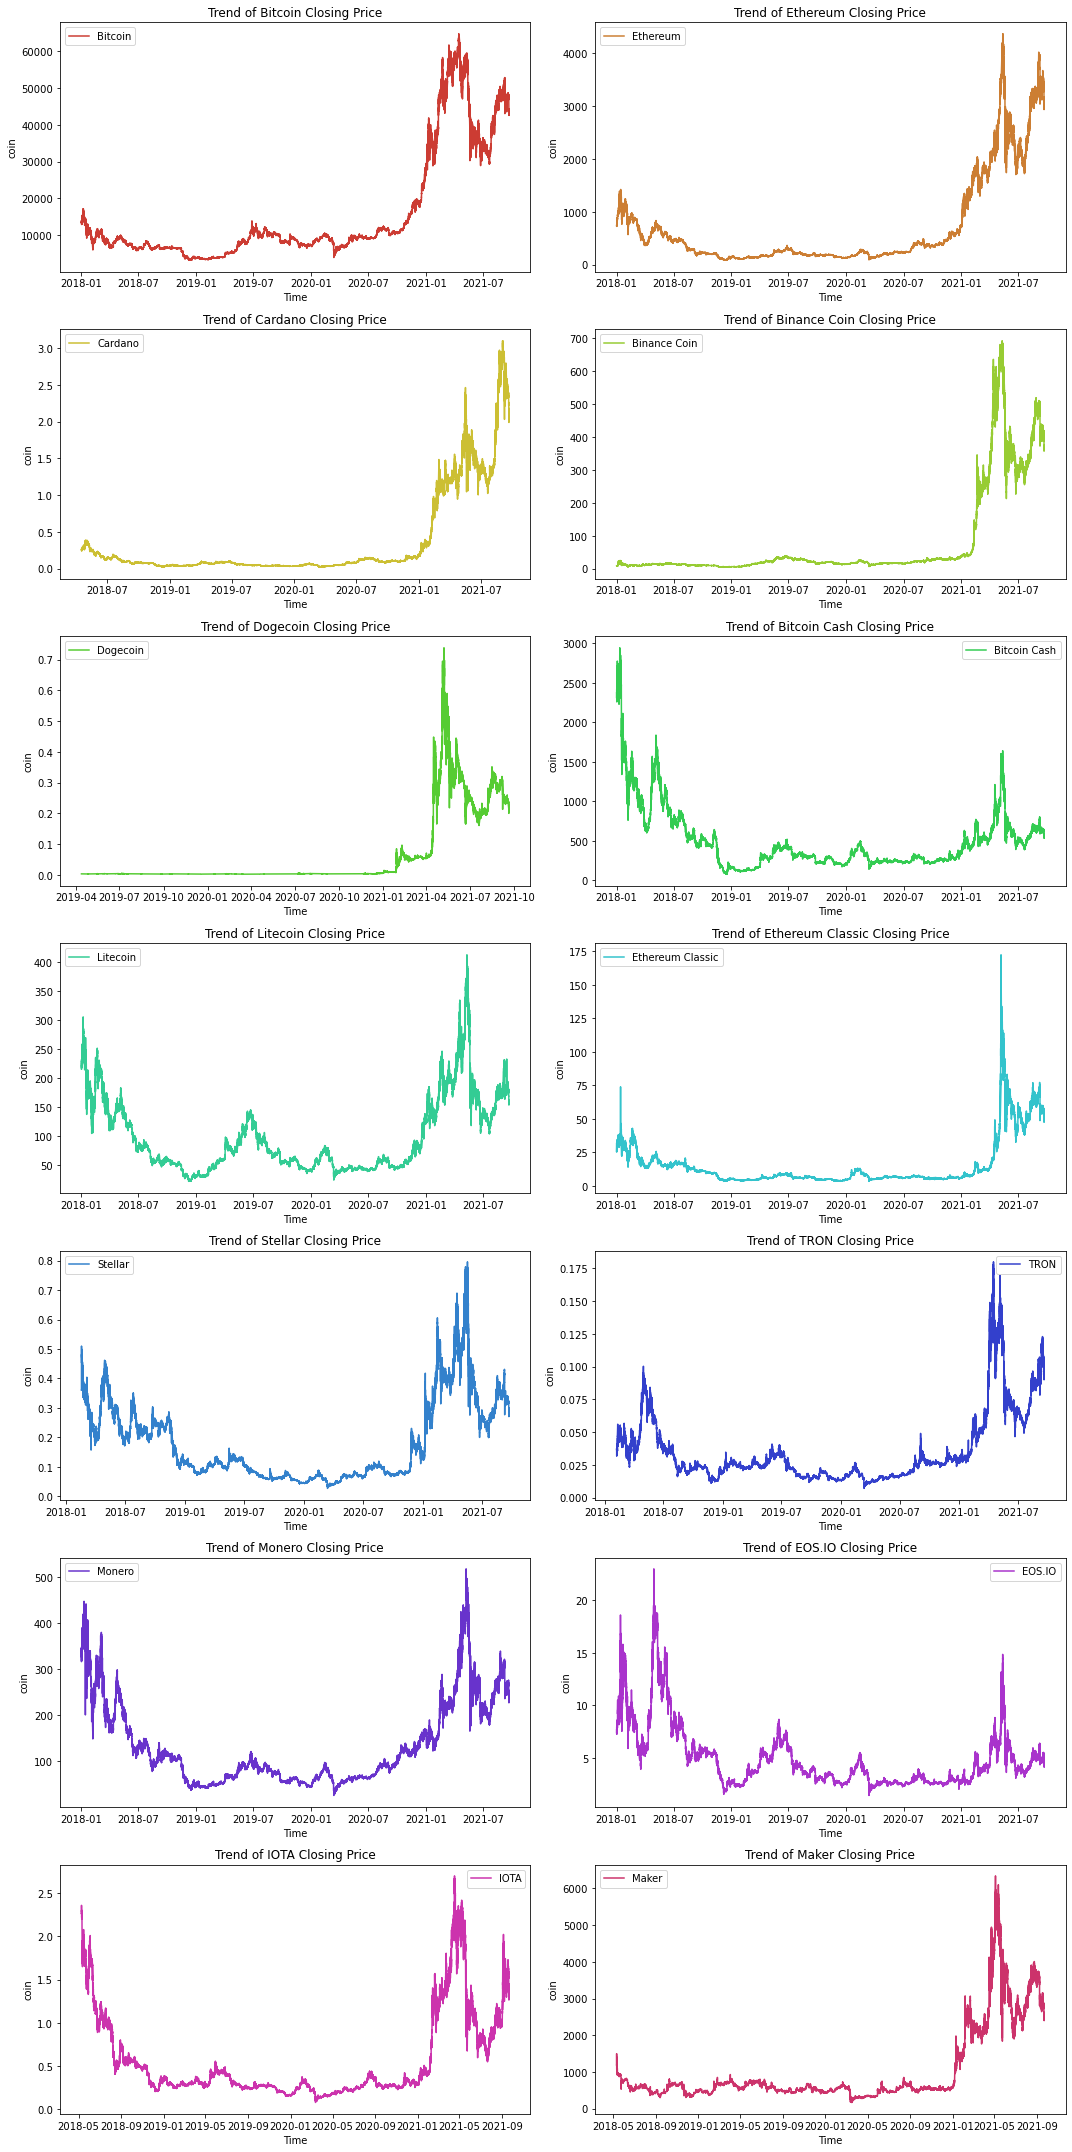

In [14]:
cmap = sns.hls_palette(14,l=.5,s=.6)
f = plt.figure(figsize=(15,30))

for index, coin in enumerate(asset_names):
    coin_df = ctrain[ctrain["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    coin_df_time = coin_df.reindex(range(coin_df.index[0], coin_df.index[-1]+60,60), method = 'pad')
    coin_df_time.index = pd.to_datetime(coin_df_time.index, unit = "s")
    ax = f.add_subplot(7,2, index+1)
    plt.plot(coin_df_time['Close'], label=coin, color=cmap[index%14])
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('coin')
    plt.title(f"Trend of {coin} Closing Price")

plt.tight_layout()
plt.show()

## Plot Closing Price Movements After June 1,2021 for All Assets

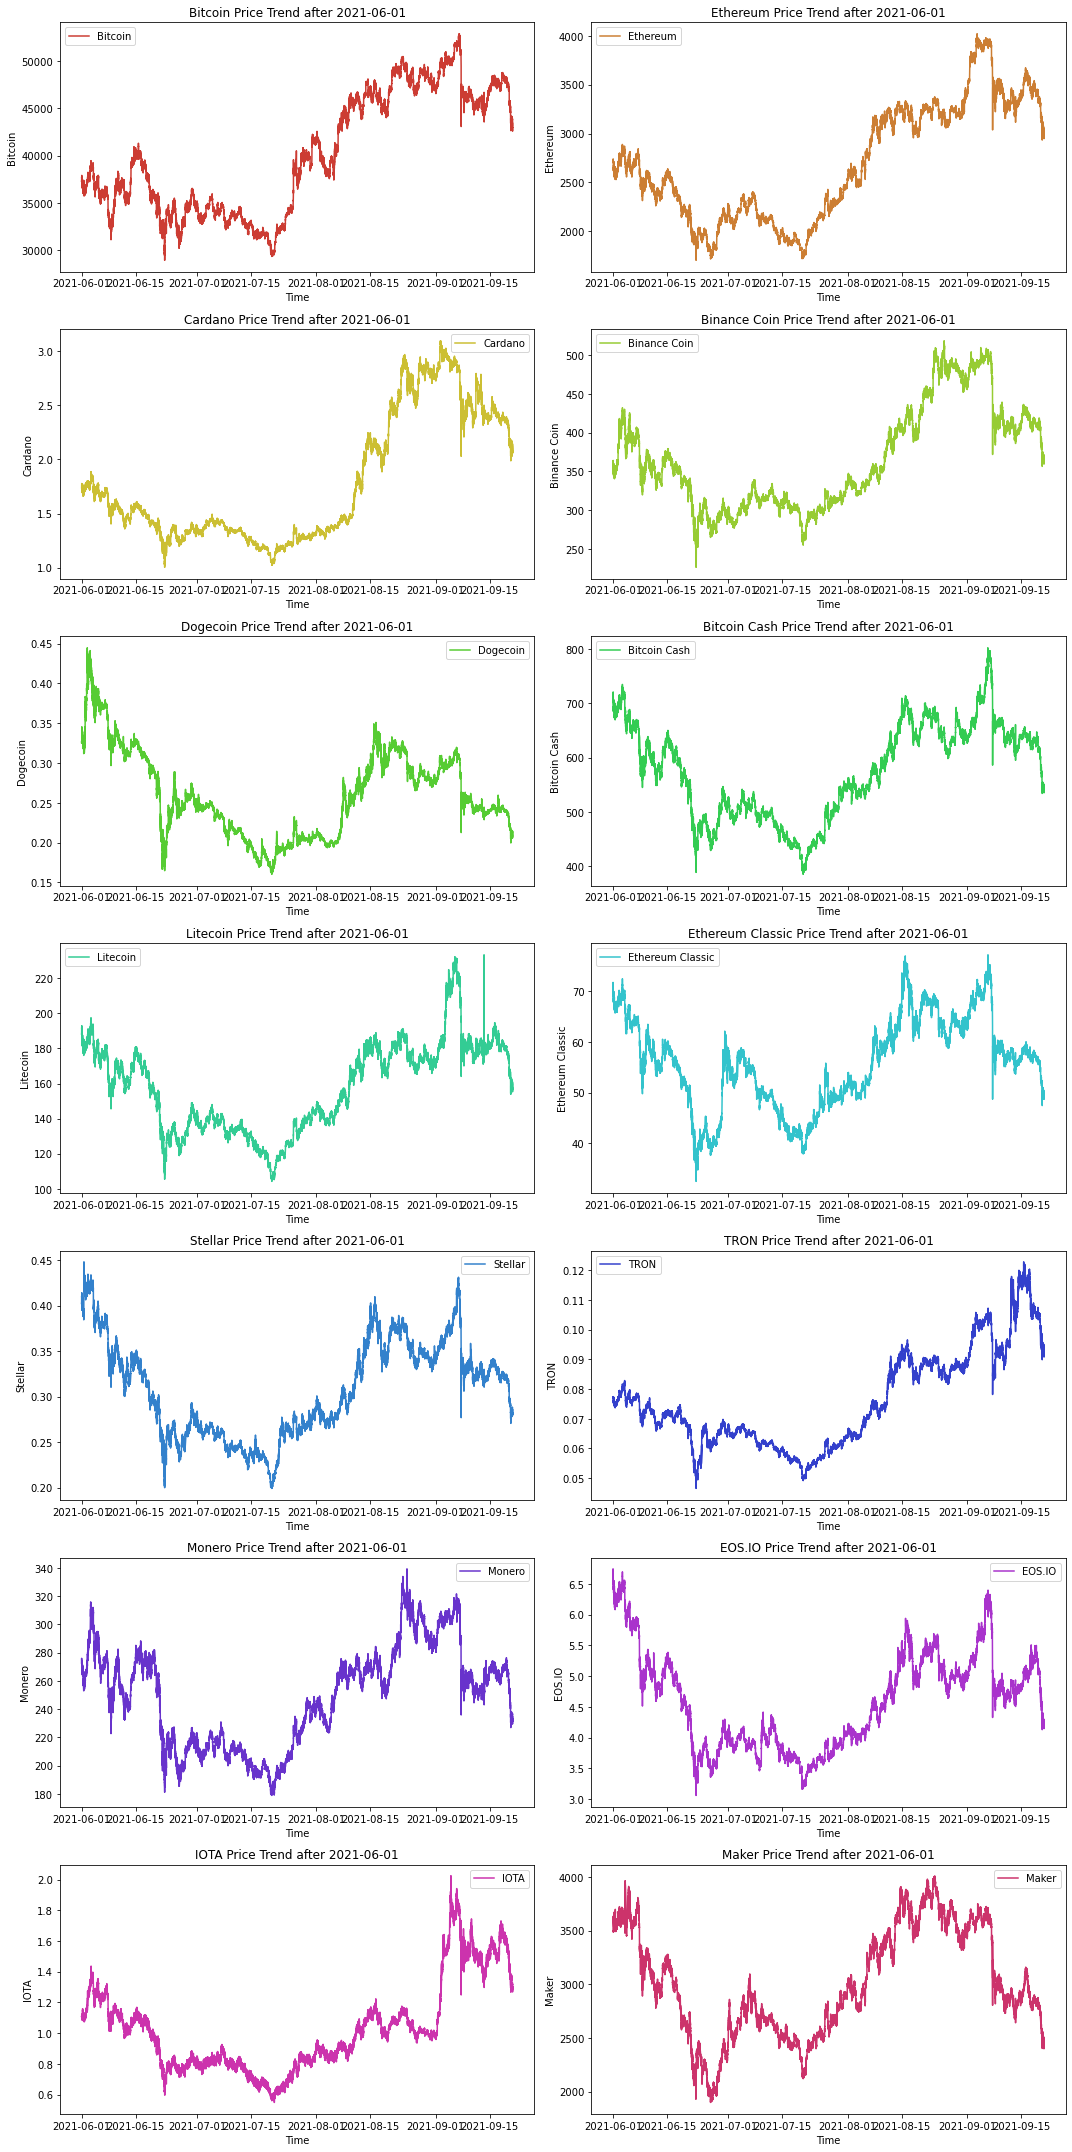

In [15]:
f = plt.figure(figsize=(15,30))

for index, coin in enumerate(asset_names):
    coin_df = ctrain[ctrain["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    coin_df_time = coin_df.reindex(range(coin_df.index[0], coin_df.index[-1]+60, 60), method = 'pad')
    coin_df_time.index = pd.to_datetime(coin_df_time.index, unit = "s")
    coin_df_time = coin_df_time.loc['06/01/2021':'09/21/2021']
    ax = f.add_subplot(7,2,index+1)
    plt.plot(coin_df_time['Close'], label=coin, color= cmap[index%14])
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel(coin)
    plt.title('%s Price Trend after 2021-06-01' %(coin))

plt.tight_layout()
plt.show()

## Correleation

### Correlation of All Coins on Actual Price Values in 2021

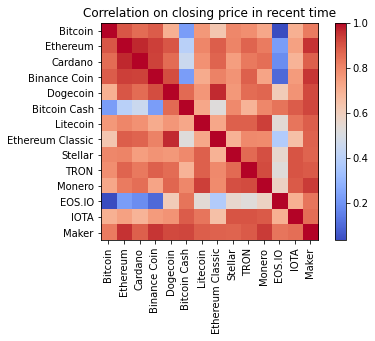

In [16]:
allcoin_df = pd.DataFrame([])

for index, coin in enumerate(asset_names):
    coin_df = ctrain[ctrain["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    coin_df_time = coin_df.reindex(range(coin_df.index[0], coin_df.index[-1]+60,60), method = 'pad')
    coin_df_time.index = pd.to_datetime(coin_df_time.index, unit = "s")
    coin_df_time = coin_df_time.loc['01/01/2021':'09/21/2021']
    close_price = coin_df["Close"].fillna(0)
    close_price.name = coin
    allcoin_df= allcoin_df.join(close_price, how="outer")
plt.imshow(allcoin_df.corr(), cmap= "coolwarm")
plt.yticks(range(14), pd.Series(asset_names).values) 
plt.xticks(range(14), pd.Series(asset_names), rotation = "vertical") 
plt.title("Correlation on closing price in recent time") 
plt.colorbar()

### Correlation of All Coins on Log Return in 2021

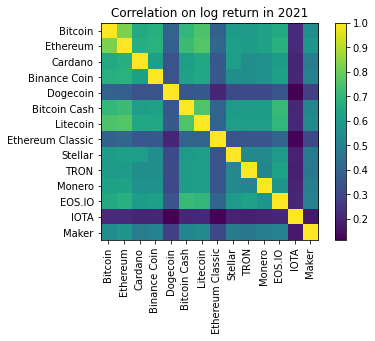

In [17]:
allcoin_df = pd.DataFrame([])

for index, coin in enumerate(asset_names):
  coin_df = ctrain[ctrain["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
  coin_df_time = coin_df.reindex(range(coin_df.index[0],coin_df.index[-1]+60,60),method='pad')
  coin_df_time.index = pd.to_datetime(coin_df_time.index, unit = 's')
  coin_df_time = coin_df_time.loc['01/01/2021':'21/09/2021']
  lret = log_return(coin_df_time.Close.fillna(0))[1:]
  allcoin_df = allcoin_df.join(lret, rsuffix=coin, how="outer")

plt.imshow(allcoin_df.corr())
plt.yticks(range(14), pd.Series(asset_names).values)
plt.xticks(range(14),pd.Series(asset_names).values, rotation='vertical')
plt.title("Correlation on log return in 2021")
plt.colorbar()

### Correlation of All Coins on Log Return for The Latest Time Period(from June 1,2021)

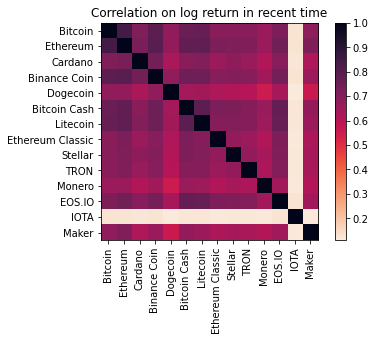

In [18]:
allcoin_lret = pd.DataFrame([])

for index, coin in enumerate(asset_names):
    coin_df = ctrain[ctrain["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    coin_df_time=coin_df.reindex(range(coin_df.index[0], coin_df.index[-1]+60, 60), method='pad')
    coin_df_time.index= pd.to_datetime(coin_df_time.index, unit='s')
    coin_df_time = coin_df_time.loc['06/01/2021':'09/21/2021']
    coin_lret = log_return(coin_df_time.Close.fillna(0))[1:]
    coin_lret.name = coin
    allcoin_lret= allcoin_lret.join(coin_lret, how="outer")
plt.imshow(allcoin_lret.corr(), cmap="rocket_r")
plt.yticks(range(14), pd.Series(asset_names).values)
plt.xticks(range(14), pd.Series(asset_names).values, rotation = "vertical")
plt.title("Correlation on log return in recent time")
plt.colorbar()

## Subgroup and Define Function for Data Visualisation and Comparison 

In [19]:
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s,"%d/%m/%Y").timetuple()))
start_time = totimestamp("01/01/2021")
end_time = totimestamp("21/09/2021")


#Subgroup Bitcoin
btc = allcoin[allcoin["Asset_ID"]==1].loc[start_time:end_time]
btc.index = pd.to_datetime(btc.index, unit = "s")

#Subgroup Ethereum
eth = allcoin[allcoin["Asset_ID"]==6].loc[start_time:end_time]
eth.index = pd.to_datetime(eth.index, unit = "s")

#Subgroup Dogecoin
doge = allcoin[allcoin["Asset_ID"]==4].loc[start_time:end_time]
doge.index = pd.to_datetime(doge.index, unit = "s")


In [20]:
#Define a function to plot the closing price and return for btc, eth and doge

def gplot(no, data, porret, label, ylabel, color):
    fig = plt.figure(figsize = (6,9))
    ax = fig.add_subplot(no)
    plt.plot(data[porret], label = label, color = color)
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    plt.xticks(rotation = 60)
    plt.tight_layout()
    plt.show()


In [21]:
#Define a function to draw candlestick charts

def cschart(data, label):
    data_recent = data.iloc[-90:]
    csc_fig = go.Figure([go.Candlestick(x = data_recent.index, open = data_recent['Open'], high = data_recent['High'], low = data_recent['Low'], close = data_recent['Close'])])
    csc_fig.update_layout(title = {'text':'{:} Candlestick Chart'.format(label), "y":0.9, "x":0.5, 'xanchor':'center', 'yanchor':'top'})
    csc_fig.update_xaxes(title_text = 'Time')
    csc_fig.update_yaxes(title_text = 'Price in USD', ticksuffix = '$')
    csc_fig.show()

## Closing Price Trend (Period: year 2021)

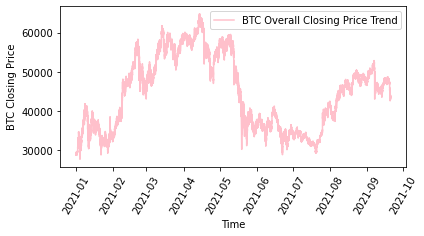

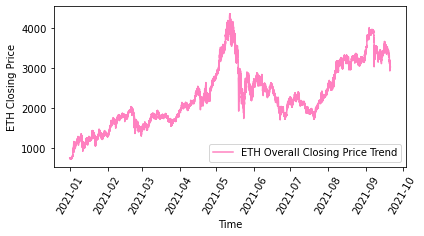

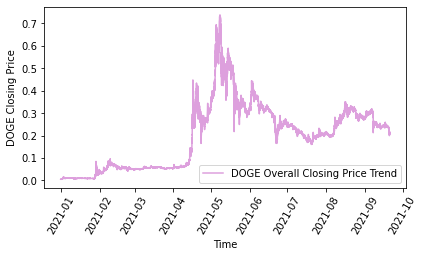

In [22]:
#BTC Price Trend
gplot(no = 311, data = btc,  porret = "Close", label = "BTC Overall Closing Price Trend", ylabel = "BTC Closing Price", color = "#FFC0CB" )

#ETH Price Trend
gplot(no = 312, data = eth, porret = "Close", label = "ETH Overall Closing Price Trend", ylabel = "ETH Closing Price", color = "#ff81c0" )

#DOGE Price Trend
gplot(no = 313, data = doge, porret = "Close", label = "DOGE Overall Closing Price Trend", ylabel = "DOGE Closing Price", color = "#dda0dd" )


## Return Trend

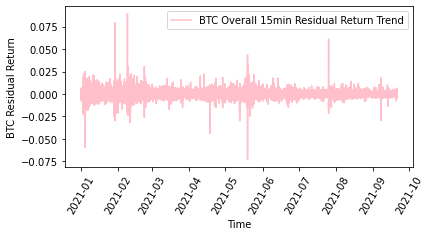

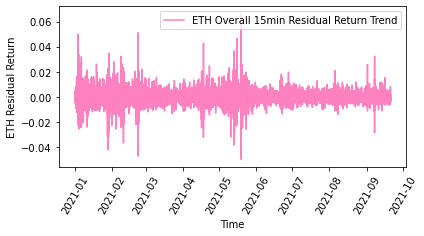

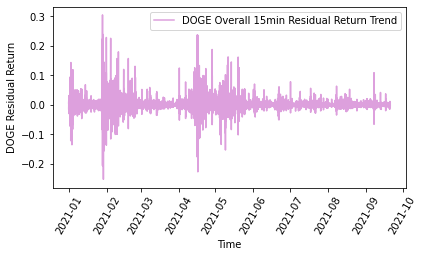

In [23]:
#BTC Return Trend
gplot(no = 311, data = btc, porret = "Target", label = "BTC Overall 15min Residual Return Trend", ylabel = "BTC Residual Return", color = "#FFC0CB" )

#ETH Return Trend
gplot(no = 312, data = eth, porret = "Target", label = "ETH Overall 15min Residual Return Trend", ylabel = "ETH Residual Return", color = "#ff81c0" )

#DOGE Return Trend
gplot(no = 313, data = doge, porret = "Target", label = "DOGE Overall 15min Residual Return Trend", ylabel = "DOGE Residual Return", color = "#dda0dd" )

## Candlestick Chart （Period: 20/09/2021)

In [24]:
cschart(btc, label = "BTC")

cschart(eth, label = "ETH")

cschart(doge, label = "DOGE")

# ARIMA Model

## Stationarity check

In [25]:
allcoin.index = pd.to_datetime(allcoin.index, unit='s')
btc_from18 =allcoin[allcoin["Asset_ID"]==1]
btc_from18 = btc_from18[["Close"]]
btc_from18_month = btc_from18.resample("M").mean()
btc_from18_month.head(10)

,Close
timestamp,
2018-01-31,12874.810724
2018-02-28,9388.864606
2018-03-31,9021.155674
2018-04-30,7982.528885
2018-05-31,8439.267129
2018-06-30,6782.353505
2018-07-31,7097.922006
2018-08-31,6689.629084
2018-09-30,6593.554500


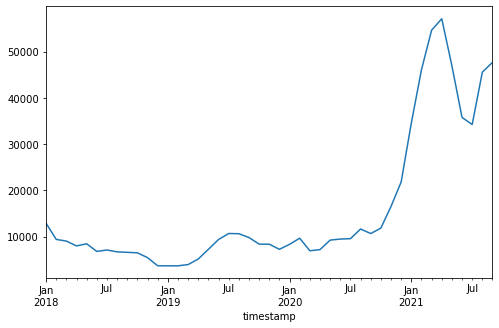

In [26]:
btc_from18_month.Close.plot(figsize=(8,5))
plt.show()

## Seasonal Decomposition

Dickey-Fuller test: p=0.902139


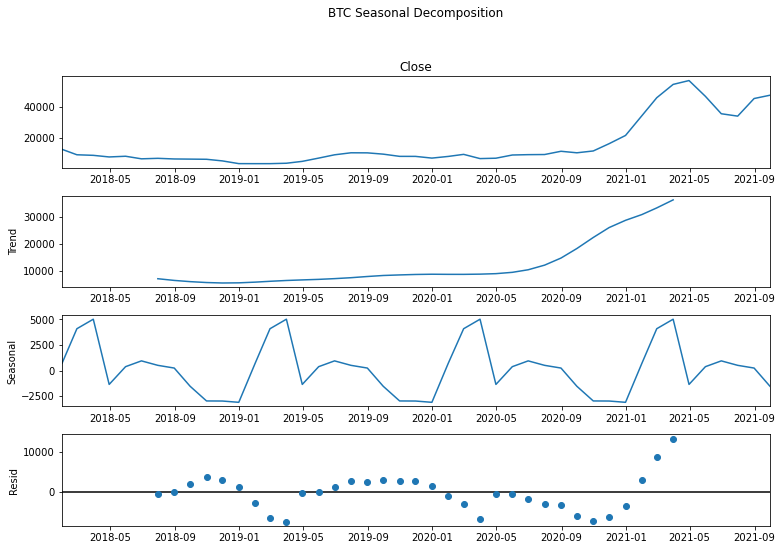

In [27]:
plt.rcParams["figure.figsize"]=(11,7) 
seasonal_decompose(btc_from18_month.Close, model='additive').plot()
print("Dickey-Fuller test: p=%f" % adfuller(btc_from18_month.Close)[1])
plt.title("BTC Seasonal Decomposition",y= 5.5, x = 0.5)
plt.show()

## Make Series Stationary

In [28]:
#Box-Cox Transformation
btc_from18_month["Close_Box"], lmbda=stats.boxcox(btc_from18_month.Close)
print("Dickey-Fuller test: p=%f" % adfuller(btc_from18_month.Close_Box)[1])

Dickey-Fuller test: p=0.865378


The p-value indicates that series is still not stationary.

When building models to forecast time series data (like ARIMA), another pre-processing step is differencing the data (calculating sequentially xt−xt−1) 

In [29]:
# Seasonal differentiation 
btc_from18_month['box_diff_seasonal_1'] = btc_from18_month.Close_Box - btc_from18_month.Close_Box.shift(1)
print("Dickey-Fuller test: p=%f" % adfuller(btc_from18_month.box_diff_seasonal_1[1:])[1])

Dickey-Fuller test: p=0.002303


The p-value indicates that series is stationary as the computed p-value is lower than the significance level alpha = 0.05.

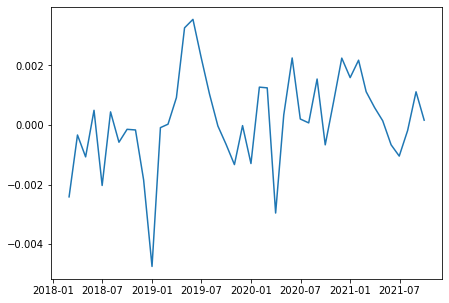

In [30]:
plt.rcParams["figure.figsize"]=(7,5) 
plt.plot(btc_from18_month['box_diff_seasonal_1'])
plt.show()

## Autocorrelation

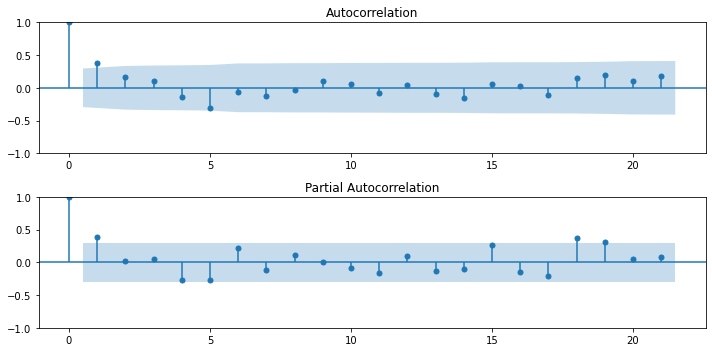

In [31]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.rcParams["figure.figsize"]=(10,5) 
ax = plt.subplot(211)
# Plot the autocorrelation function
plot_acf(btc_from18_month.box_diff_seasonal_1[1:].values.squeeze(), lags=21, ax=ax)
ax = plt.subplot(212)
plot_pacf(btc_from18_month.box_diff_seasonal_1[1:].values.squeeze(), lags=21, ax=ax)
plt.tight_layout()
plt.show()

## ARIMA Model

p - the number of lag observations to include in the model, or lag order. (AR)

d - the number of times that the raw observations are differenced, or the degree of differencing. (I)

q - the size of the moving average window, also called the order of moving average.(MA)

In [32]:
# Initial approximation of parameters
qs = range(0, 3)  #0,1,2
ps = range(0, 3)  #0,1,2  
d=1
parameters = product(ps, qs) 
parameters_list = list(parameters)
len(parameters_list)

# Model Selection： 
results = []
best_aic = float("inf") 
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(btc_from18_month.Close_Box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [33]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters         aic
3     (1, 0) -446.120663
1     (0, 1) -445.330852
6     (2, 0) -444.157743
4     (1, 1) -444.142122
2     (0, 2) -442.744921


In [34]:
print(best_model.summary()) 

                               SARIMAX Results                                
Dep. Variable:              Close_Box   No. Observations:                   45
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 225.060
Date:                Wed, 02 Nov 2022   AIC                           -446.121
Time:                        20:53:57   BIC                           -442.552
Sample:                    01-31-2018   HQIC                          -444.797
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3820      0.133      2.869      0.004       0.121       0.643
sigma2      2.101e-06   4.33e-07      4.850      0.000    1.25e-06    2.95e-06
Ljung-Box (L1) (Q):                   0.02   Jarque-

## Analysis of Results

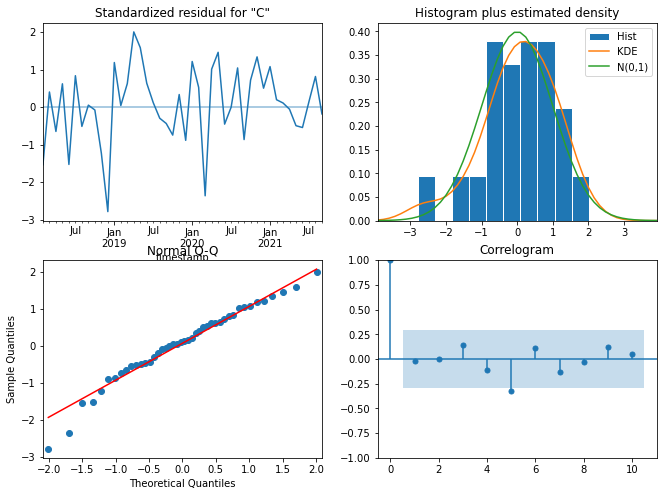

In [35]:
best_model.plot_diagnostics(figsize=(11, 8))
plt.show()

The standardized residual plot doesn't display any obvious seasonality. 

In the histogram, the KDE line indicates the residuals are nearly normally distributed.

In the Q-Q-plot the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). 

Last graph shows that the time series residuals have low correlation with lagged versions of itself.

Conclusion: We may consider trying to standardise the distribution further. 

## Prediction

In [36]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

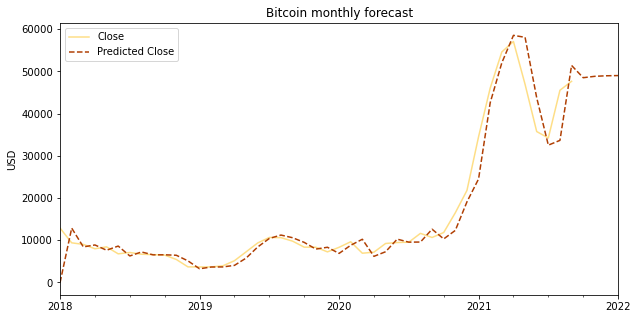

In [37]:
# Prediction
plt.rcParams["figure.figsize"]=(10,5) 
btc_month_pred = btc_from18_month[['Close']]
date_list = [datetime(2021, 10, 31), datetime(2021, 11, 30), datetime(2021, 12, 31), datetime(2022, 1, 31)]
future = pd.DataFrame(index=date_list, columns= btc_from18_month.columns)
btc_month_pred = pd.concat([btc_month_pred, future])
btc_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2018, 1, 31), end=datetime(2022, 1, 31)), lmbda)
#Plot
btc_month_pred.Close.plot(color='#fede86')
btc_month_pred.forecast.plot(color='#b03f03', ls='--', label='Predicted Close')
plt.legend()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')
plt.show()

# SARIMAX Model

## Parameters Selection

In [38]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters2 = product(ps, qs, Ps, Qs)
parameters2_list = list(parameters2)

In [39]:
# Model Selection
results2 = []
best_aic2 = float("inf")
warnings.filterwarnings('ignore')
for param in parameters2_list:
    try:
   # not good: model2 = SARIMAX(btc_from18_month.Close_Box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
         model2 = SARIMAX(btc_from18_month.Close_Box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic2 = model2.aic
    if aic2 < best_aic2:
        best_model2 = model2
        best_aic2 = aic2
        best_param2 = param
    results.append([param, model.aic])

In [40]:
# Best Models
result_table2 = pd.DataFrame(results)
result_table2.columns = ['parameters', 'aic']
print(result_table2.sort_values(by = 'aic', ascending=True).head())

  parameters         aic
3     (1, 0) -446.120663
1     (0, 1) -445.330852
6     (2, 0) -444.157743
4     (1, 1) -444.142122
2     (0, 2) -442.744921


In [41]:
print(best_model2.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         Close_Box   No. Observations:                   45
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 4)   Log Likelihood                 199.956
Date:                           Wed, 02 Nov 2022   AIC                           -391.913
Time:                                   20:54:07   BIC                           -385.157
Sample:                               01-31-2018   HQIC                          -389.470
                                    - 09-30-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4240      0.160      2.651      0.008       0.111       0.737
ar.S.L4       -0.8207      0.152     -5.394

## Analysis of Results

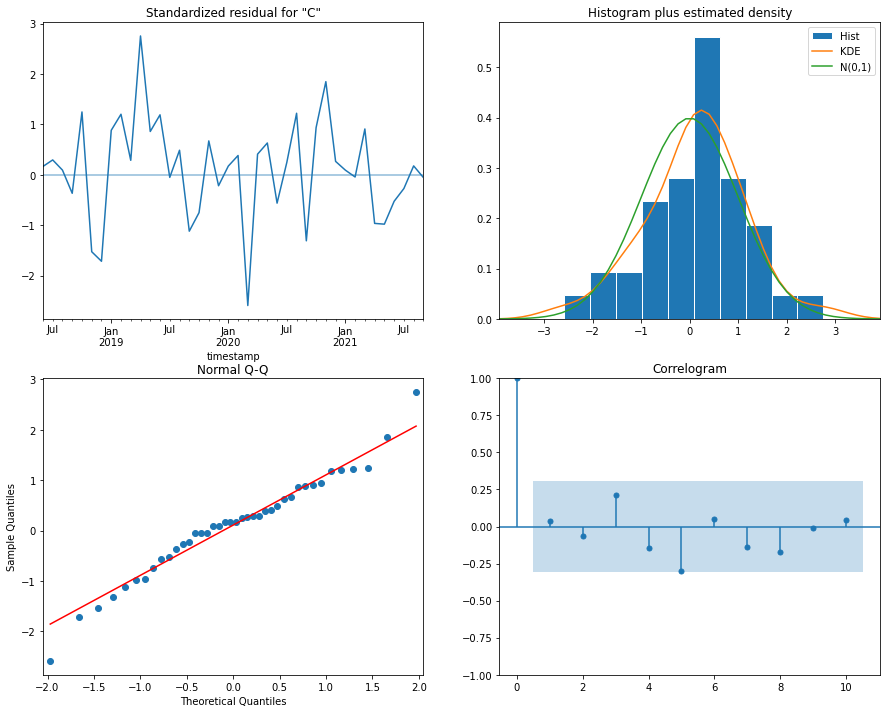

In [42]:
best_model2.plot_diagnostics(figsize=(15, 12))
plt.show()

Dickey-Fuller test:: p=0.000008


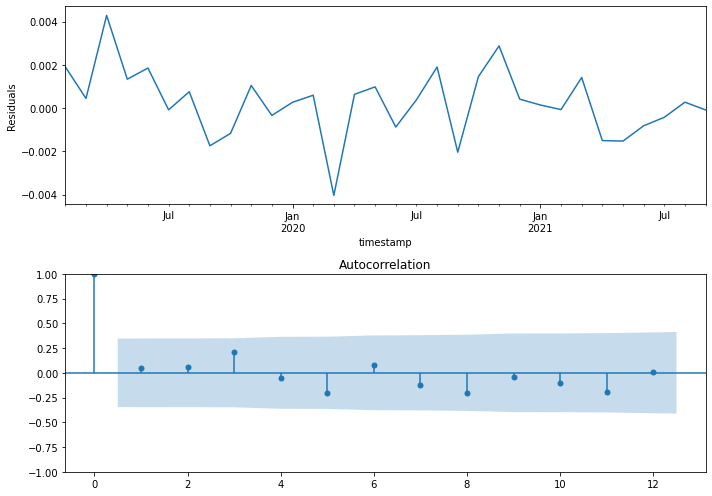

In [43]:
# STL-decomposition
plt.figure(figsize=(10,7))
plt.subplot(211)
best_model2.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
plot_acf(best_model2.resid[13:].values.squeeze(), lags=12, ax=ax)
print("Dickey-Fuller test:: p=%f" % adfuller(best_model2.resid[13:])[1])
plt.tight_layout()
plt.show()

## Prediction

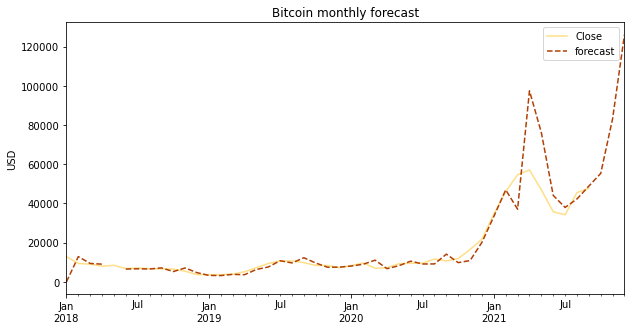

In [44]:
plt.rcParams["figure.figsize"]=(10,5) 
btc_month_pred2 = btc_from18_month[['Close']]
date_list = [datetime(2021, 10, 31), datetime(2021, 11, 30), datetime(2021, 12, 31)]
future = pd.DataFrame(index=date_list, columns= btc_from18_month.columns)
btc_month_pred2 = pd.concat([btc_month_pred2, future])
btc_month_pred2['forecast'] = invboxcox(best_model2.predict(start=datetime(2018, 1, 31), end=datetime(2022, 1, 31)), lmbda)
#Plot
btc_month_pred2.Close.plot(color='#fede86')
btc_month_pred2.forecast.plot(color='#b03f03', ls='--', label='forecast')
plt.legend()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')
plt.show()

# Model Validation 

In [45]:
#SARIMA RMSE
y_forecasted2 = btc_month_pred2.forecast
y_truth2 = btc_month_pred2['2019-01-01':'2021-01-01'].Close
# Compute the root mean square error
rmse = np.sqrt(((y_forecasted2 - y_truth2) ** 2).mean())
print('RMSE: {}'.format(round(rmse, 2)))

RMSE: 1972.34


In [46]:
#ARIMA RMSE
y_forecasted = btc_month_pred.forecast
y_truth = btc_month_pred['2019-01-01':'2021-01-01'].Close
# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('RMSE: {}'.format(round(rmse, 2)))

RMSE: 1617.78


The ARIMA prediction shown in the chart is quite good before 2021 and has the same trend with the real price even in the following crazy year. However, the models are still a little rough and apparently not something we should use as trading advice. But that was not unexpected due to the extremely volatile nature of cryptocurrencies.

It is probably also not such a good idea to try and predict 3 months into the future. Maybe predicting on a daily basis.

# Data Comparison

In [48]:
import yfinance as yf

In [49]:
BTC_Ticker = yf.Ticker("BTC-USD")
BTC_Data = BTC_Ticker.history(start="2021-09-30", end="2022-01-31", interval="1h")
BTC_month = BTC_Data.resample("M").mean()
BTC_month.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2021-09-30 00:00:00+00:00,43193.263587,43469.551121,43034.645720,43291.617697,1.573104e+08,0.0,0.0
2021-10-31 00:00:00+00:00,57656.204487,57902.965440,57418.436679,57678.278460,2.714793e+08,0.0,0.0
2021-11-30 00:00:00+00:00,60685.376508,60932.780132,60434.545280,60680.843132,2.982261e+08,0.0,0.0
2021-12-31 00:00:00+00:00,49464.910804,49673.594713,49232.656366,49452.603774,2.568657e+08,0.0,0.0
2022-01-31 00:00:00+00:00,41230.871398,41372.186168,41080.433014,41223.821522,4.658862e+08,0.0,0.0


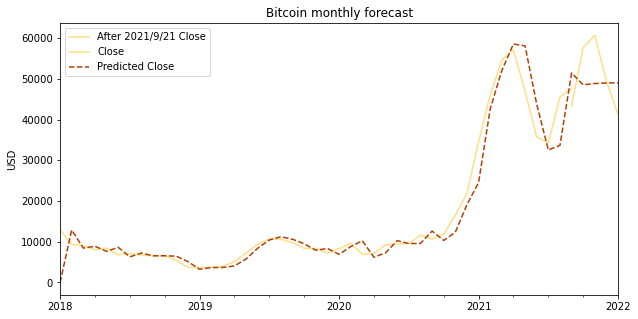

In [52]:
# Prediction(ARIMA)
plt.rcParams["figure.figsize"]=(10,5) 
btc_month_pred = btc_from18_month[['Close']]
date_list = [datetime(2021, 10, 31), datetime(2021, 11, 30), datetime(2021, 12, 31), datetime(2022, 1, 31)]
future = pd.DataFrame(index=date_list, columns= btc_from18_month.columns)
btc_month_pred = pd.concat([btc_month_pred, future])
btc_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2018, 1, 31), end=datetime(2022, 1, 31)), lmbda)
#Plot
BTC_month.Close.plot(color='#fede86', label='After 2021/9/21 Close')
btc_month_pred.Close.plot(color='#fede86')
btc_month_pred.forecast.plot(color='#b03f03', ls='--', label='Predicted Close')
plt.legend()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')
plt.show()

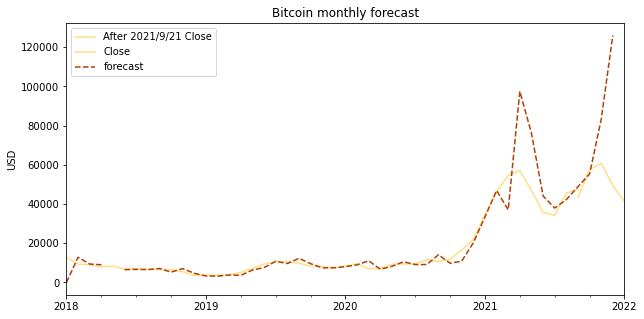

In [53]:
# Prediction(SARIMA)
plt.rcParams["figure.figsize"]=(10,5) 
btc_month_pred2 = btc_from18_month[['Close']]
date_list = [datetime(2021, 10, 31), datetime(2021, 11, 30), datetime(2021, 12, 31)]
future = pd.DataFrame(index=date_list, columns= btc_from18_month.columns)
btc_month_pred2 = pd.concat([btc_month_pred2, future])
btc_month_pred2['forecast'] = invboxcox(best_model2.predict(start=datetime(2018, 1, 31), end=datetime(2022, 1, 31)), lmbda)
#Plot
BTC_month.Close.plot(color='#fede86', label='After 2021/9/21 Close')
btc_month_pred2.Close.plot(color='#fede86')
btc_month_pred2.forecast.plot(color='#b03f03', ls='--', label='forecast')
plt.legend()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')
plt.show()